## Máster en Big Data y Data Science

### Metodologías de gestión y diseño de proyectos de big data

#### AP2 - Extracción de reglas de pertenencia a grupos

##### Árboles de Decisión

---

En esta libreta se toman los resultados de la clusterización para realizar la extracción de reglas que permitan comprender de qué manera fueron conformados los grupos. 

---

### Carga de librerias a utilizar

In [23]:
# Se importan las librerias a utilizar
import pandas as pd

# Para registro de toda la experimentación
import mlflow

# Para la generación de los sets de train - test
from sklearn.model_selection import train_test_split

# Importaciones varias para la evaluación
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Importación para la exportación a texto de las reglas del árbol
from sklearn.tree import export_text

# Para la visualización de los resultados
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

### Lectura del dataset generado previamente

In [2]:
# Se hace la lectura del dataset del seminario y se obtiene su cabecera
datos = pd.read_csv('../data/final/df_agc_k2.csv', sep=';')
datos.head()

,edad,importe_solicitado,duracion_credito,antiguedad_empleado,ingresos,pct_ingreso,tasa_interes,estado_credito,antiguedad_cliente,gastos_ult_12m,...,nivel_educativo_POSGRADO_COMPLETO,nivel_educativo_POSGRADO_INCOMPLETO,nivel_educativo_SECUNDARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_INCOMPLETO,nivel_tarjeta_Blue,nivel_tarjeta_Gold,nivel_tarjeta_Platinum,nivel_tarjeta_Silver,cluster
0,22.0,35000.0,3.0,123.0,59000.0,0.59,16.02,1.0,36.0,1088.0,...,False,False,False,True,False,True,False,False,False,0
1,21.0,1000.0,2.0,5.0,9600.0,0.10,11.14,0.0,39.0,1144.0,...,False,False,True,False,False,True,False,False,False,0
2,23.0,35000.0,2.0,4.0,65500.0,0.53,15.23,1.0,36.0,1887.0,...,False,False,False,True,False,True,False,False,False,0
3,24.0,35000.0,4.0,8.0,54400.0,0.55,14.27,1.0,54.0,1314.0,...,False,False,False,False,False,True,False,False,False,0
4,21.0,2500.0,2.0,2.0,9900.0,0.25,7.14,1.0,34.0,1171.0,...,False,False,True,False,False,True,False,False,False,0


### Armado de los sets de entrenamiento y testeo

In [4]:
# Se separan los atributos de datos de los de la etiqueta del dataset

# Ensure the 'cluster' column exists in the DataFrame
if 'cluster' in datos.columns:
    labels = datos['cluster'].astype('str')  # Convert to string
else:
    raise KeyError("The 'cluster' column is missing in the DataFrame.")

features = datos[['edad', 'importe_solicitado', 'duracion_credito',
       'antiguedad_empleado', 'ingresos', 'pct_ingreso', 'tasa_interes',
       'estado_credito', 'antiguedad_cliente', 'gastos_ult_12m',
       'limite_credito_tc',  'personas_a_cargo',
       'situacion_vivienda_ALQUILER', 'situacion_vivienda_HIPOTECA',
       'situacion_vivienda_OTROS', 'situacion_vivienda_PROPIA',
       'objetivo_credito_EDUCACIÓN', 'objetivo_credito_INVERSIONES',
       'objetivo_credito_MEJORAS_HOGAR', 'objetivo_credito_PAGO_DEUDAS',
       'objetivo_credito_PERSONAL', 'objetivo_credito_SALUD', 'falta_pago_N',
       'falta_pago_Y', 'estado_civil_CASADO',
       'estado_civil_DESCONOCIDO', 'estado_civil_DIVORCIADO',
       'estado_civil_SOLTERO', 'estado_cliente_ACTIVO',
       'estado_cliente_PASIVO', 'genero_F', 'genero_M',
       'nivel_educativo_DESCONOCIDO', 'nivel_educativo_POSGRADO_COMPLETO',
       'nivel_educativo_POSGRADO_INCOMPLETO',
       'nivel_educativo_SECUNDARIO_COMPLETO',
       'nivel_educativo_UNIVERSITARIO_COMPLETO',
       'nivel_educativo_UNIVERSITARIO_INCOMPLETO']]

print(f"Vista de los datos del atributo target: \n{labels[:10]}")
print("-"*50)
print("Vista parcial de los datos sin el atributo target:")
features.head()

Vista de los datos del atributo target: 
0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: cluster, dtype: object
--------------------------------------------------
Vista parcial de los datos sin el atributo target:


,edad,importe_solicitado,duracion_credito,antiguedad_empleado,ingresos,pct_ingreso,tasa_interes,estado_credito,antiguedad_cliente,gastos_ult_12m,...,estado_cliente_ACTIVO,estado_cliente_PASIVO,genero_F,genero_M,nivel_educativo_DESCONOCIDO,nivel_educativo_POSGRADO_COMPLETO,nivel_educativo_POSGRADO_INCOMPLETO,nivel_educativo_SECUNDARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_INCOMPLETO
0,22.0,35000.0,3.0,123.0,59000.0,0.59,16.02,1.0,36.0,1088.0,...,True,False,False,True,False,False,False,False,True,False
1,21.0,1000.0,2.0,5.0,9600.0,0.10,11.14,0.0,39.0,1144.0,...,True,False,False,True,False,False,False,True,False,False
2,23.0,35000.0,2.0,4.0,65500.0,0.53,15.23,1.0,36.0,1887.0,...,True,False,False,True,False,False,False,False,True,False
3,24.0,35000.0,4.0,8.0,54400.0,0.55,14.27,1.0,54.0,1314.0,...,True,False,False,True,True,False,False,False,False,False
4,21.0,2500.0,2.0,2.0,9900.0,0.25,7.14,1.0,34.0,1171.0,...,True,False,True,False,False,False,False,True,False,False


In [5]:
# Se pasa a binarizar los atributos

data = pd.get_dummies(features)
data.head()

,edad,importe_solicitado,duracion_credito,antiguedad_empleado,ingresos,pct_ingreso,tasa_interes,estado_credito,antiguedad_cliente,gastos_ult_12m,...,estado_cliente_ACTIVO,estado_cliente_PASIVO,genero_F,genero_M,nivel_educativo_DESCONOCIDO,nivel_educativo_POSGRADO_COMPLETO,nivel_educativo_POSGRADO_INCOMPLETO,nivel_educativo_SECUNDARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_COMPLETO,nivel_educativo_UNIVERSITARIO_INCOMPLETO
0,22.0,35000.0,3.0,123.0,59000.0,0.59,16.02,1.0,36.0,1088.0,...,True,False,False,True,False,False,False,False,True,False
1,21.0,1000.0,2.0,5.0,9600.0,0.10,11.14,0.0,39.0,1144.0,...,True,False,False,True,False,False,False,True,False,False
2,23.0,35000.0,2.0,4.0,65500.0,0.53,15.23,1.0,36.0,1887.0,...,True,False,False,True,False,False,False,False,True,False
3,24.0,35000.0,4.0,8.0,54400.0,0.55,14.27,1.0,54.0,1314.0,...,True,False,False,True,True,False,False,False,False,False
4,21.0,2500.0,2.0,2.0,9900.0,0.25,7.14,1.0,34.0,1171.0,...,True,False,True,False,False,False,False,True,False,False


In [6]:
# Para evitar problemas con mlfow se hace una conversión de integer a double 
# de los atributos: 'importe_solicitado', 'duracion_credito', 'estado_credito'

# Se filtran las columnas del tipo integer
integer_columns = data.select_dtypes(include='int').columns

# Convert integer columns to double
data[integer_columns] = data[integer_columns].astype('float')

In [7]:
# Se reparten los datos disponibles en conjuntos para entrenamiento y testeo

train_data, test_data, train_labels, test_labels = train_test_split(data, labels) 

# Toma por defecto 75% (entrenamiento) - 25% (testeo)

# Vista de los datos de entrenamiento para una fila

print(f"Un registro de entrenamiento: \n{train_data.iloc[0]}")
print("-"*50)
print(f"Label del registro: \n{train_labels.iloc[0]}\n")

print("#"*50)
print("#"*50)

# Vista de los datos de testeo para una fila

print(f"\nUn registro de testeo: \n{test_data.iloc[0]}")
print("-"*50)
print(f"Label del registro: \n{test_labels.iloc[0]}")

Un registro de entrenamiento: 
edad                                           26.0
importe_solicitado                          13000.0
duracion_credito                                2.0
antiguedad_empleado                             0.0
ingresos                                    28800.0
pct_ingreso                                    0.45
tasa_interes                                  14.46
estado_credito                                  1.0
antiguedad_cliente                             28.0
gastos_ult_12m                               1926.0
limite_credito_tc                            2707.0
personas_a_cargo                                1.0
situacion_vivienda_ALQUILER                    True
situacion_vivienda_HIPOTECA                   False
situacion_vivienda_OTROS                      False
situacion_vivienda_PROPIA                     False
objetivo_credito_EDUCACIÓN                    False
objetivo_credito_INVERSIONES                  False
objetivo_credito_MEJORAS_HOGAR   

In [8]:
# Configuración de la evaluación

def evaluar_modelo(modelo, test_data, test_labels):
    prediction = modelo.predict(test_data)
    print('Rendimiento obtenido:',accuracy_score(test_labels,prediction))
    print('Reporte de indicadores:\n',classification_report(test_labels,prediction))
    print('Matriz de confusión:')
    cm = confusion_matrix(test_labels, prediction, labels=modelo.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=modelo.classes_)
    disp.plot()
    plt.show()
    plt.close()

In [9]:
# Para obtener todos los parámetros y no solo los modificados

from sklearn import set_config

set_config(print_changed_only=False)

### Generación de modelos

Se pasa a configurar la serie de experimentos en **mlflow**

In [10]:
# Se establece un nombre para identificar la serie de experimentos

mlflow.set_experiment(experiment_name="Reglas - Prueba #1 - Agg Clustering K=2 Sin normalizar")
mlflow.autolog()

2025/05/08 18:10:09 INFO mlflow.tracking.fluent: Experiment with name 'Reglas - Prueba #1 - Agg Clustering K=2 Sin normalizar' does not exist. Creating a new experiment.
2025/05/08 18:10:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


#### Árboles de Decisión (TDIDT)

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

with mlflow.start_run(run_name='Decision Tree'):
    dtc = DecisionTreeClassifier(max_depth=3, 
                                 criterion='entropy', 
                                 min_samples_split=10)

    dtc.fit(train_data, train_labels)

    # Se finaliza el registro
    mlflow.end_run()

2025/05/08 18:10:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [12]:
dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=None, splitter='best')

Rendimiento obtenido: 0.9995499549954996
Reporte de indicadores:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      0.99      0.99        92

    accuracy                           1.00      2222
   macro avg       1.00      0.99      1.00      2222
weighted avg       1.00      1.00      1.00      2222

Matriz de confusión:


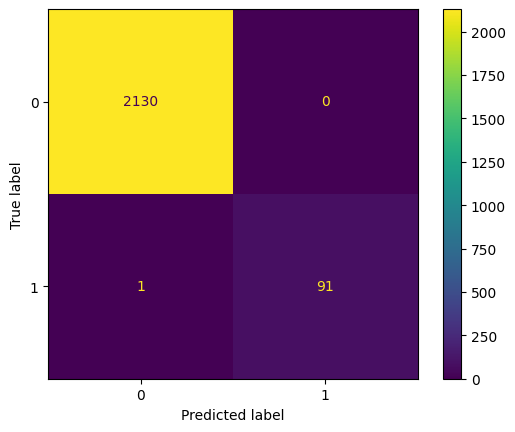

In [13]:
evaluar_modelo(dtc, test_data, test_labels)

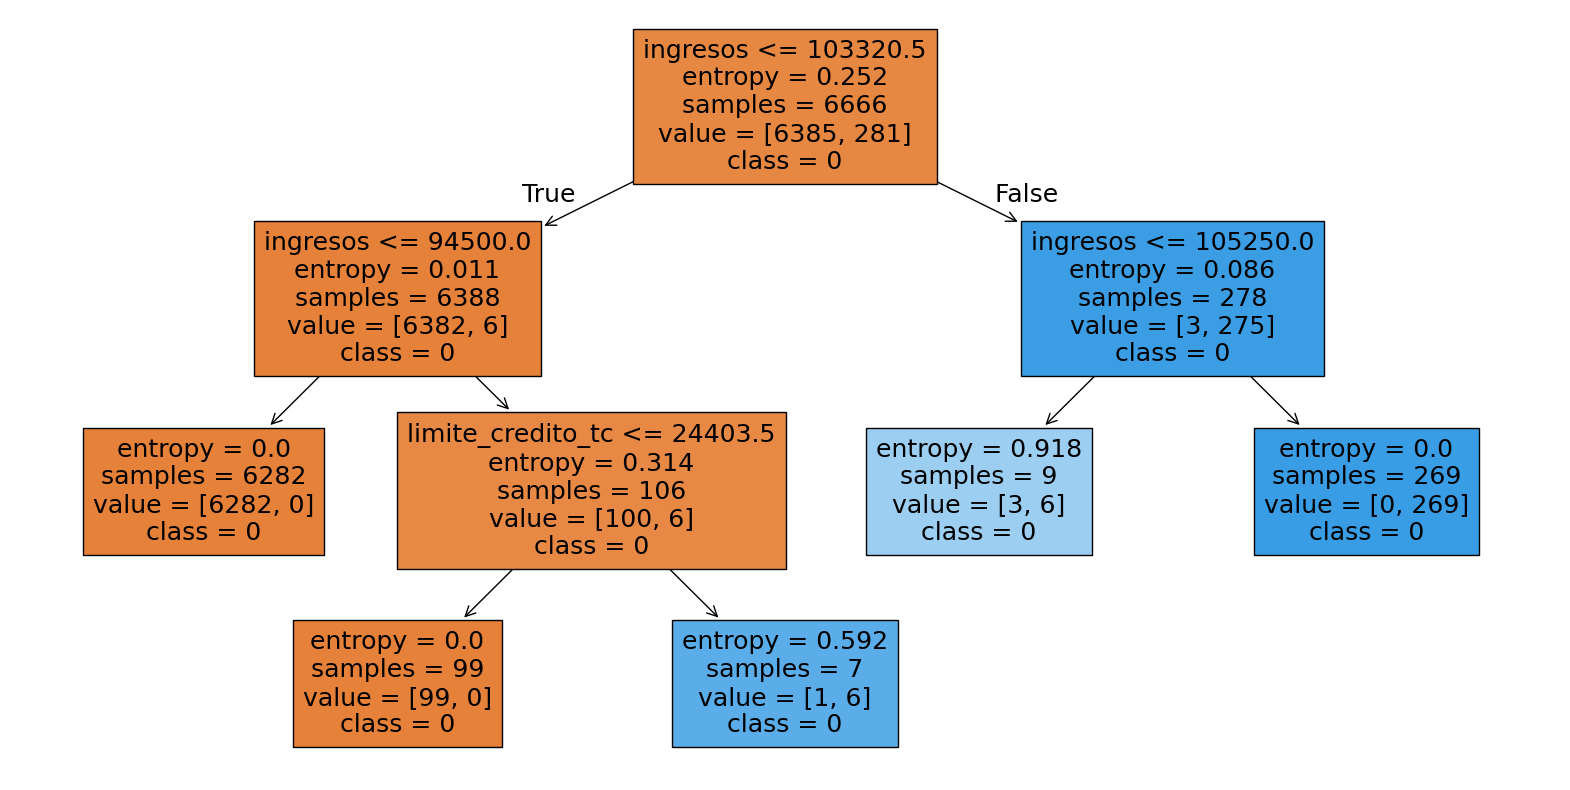

In [14]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=data.columns, class_names=labels)
plt.show()
plt.close()

In [15]:
# Exportar las reglas del árbol
rules = export_text(dtc, feature_names=list(data.columns))
print(rules)

|--- ingresos <= 103320.50
|   |--- ingresos <= 94500.00
|   |   |--- class: 0
|   |--- ingresos >  94500.00
|   |   |--- limite_credito_tc <= 24403.50
|   |   |   |--- class: 0
|   |   |--- limite_credito_tc >  24403.50
|   |   |   |--- class: 1
|--- ingresos >  103320.50
|   |--- ingresos <= 105250.00
|   |   |--- class: 1
|   |--- ingresos >  105250.00
|   |   |--- class: 1



Prueba #1 - Ejecución #2 con DT (cambiando parámetros)

In [16]:
with mlflow.start_run(run_name='Decision Tree'):
    dtc = DecisionTreeClassifier(max_depth=5, 
                                 criterion='entropy', 
                                 min_samples_split=5)

    dtc.fit(train_data, train_labels)
    

    # Se finaliza el registro
    mlflow.end_run()

2025/05/08 18:38:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


In [17]:
dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=None, splitter='best')

Rendimiento obtenido: 0.9995499549954996
Reporte de indicadores:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      0.99      0.99        92

    accuracy                           1.00      2222
   macro avg       1.00      0.99      1.00      2222
weighted avg       1.00      1.00      1.00      2222

Matriz de confusión:


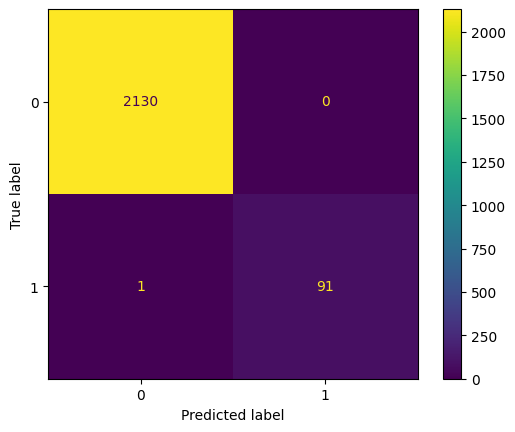

In [18]:
evaluar_modelo(dtc, test_data, test_labels)

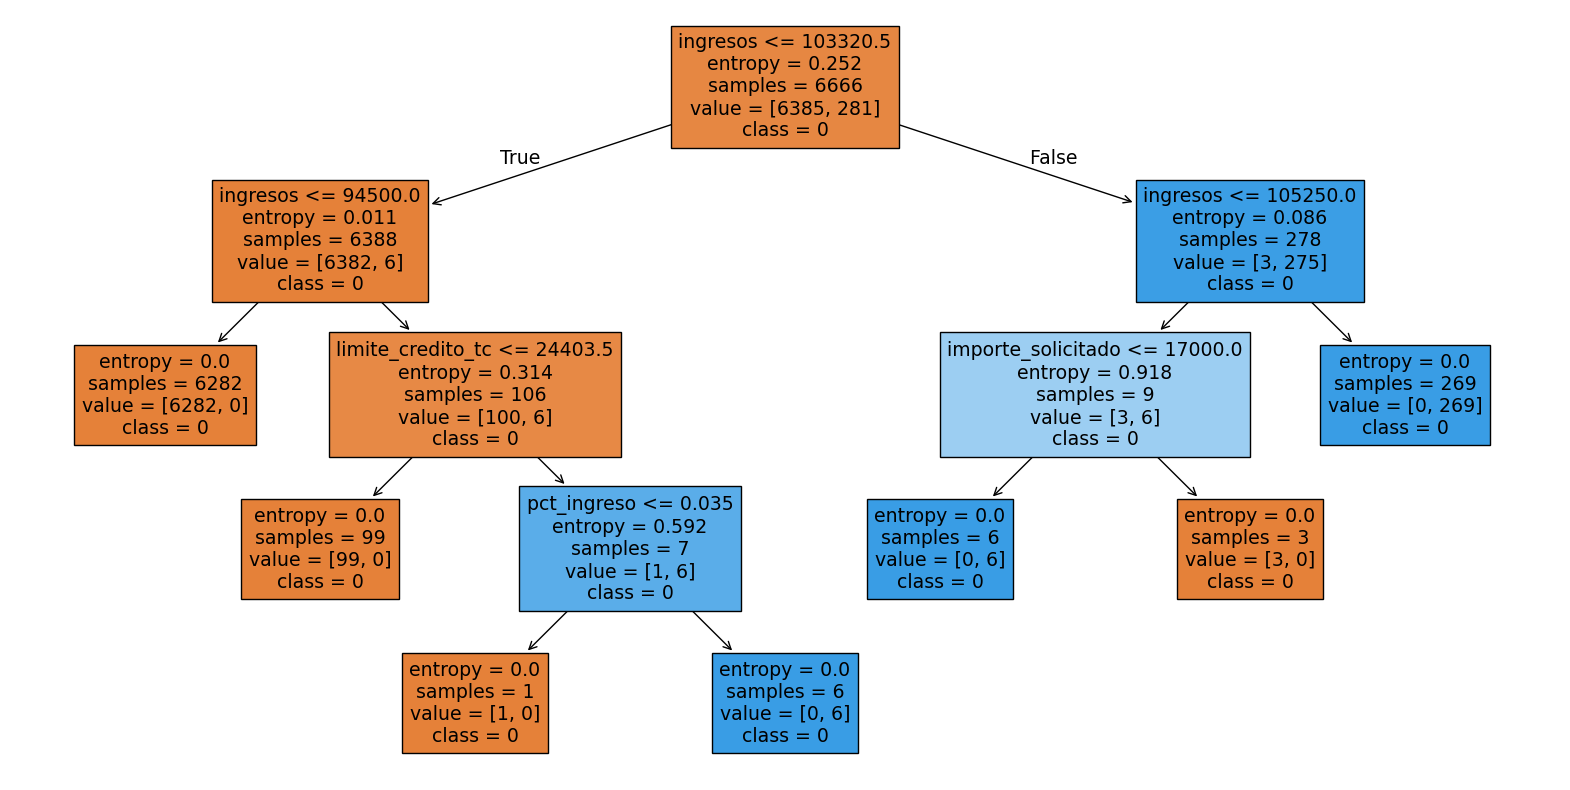

In [19]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=data.columns, class_names=labels)
plt.show()
plt.close()

In [20]:
# Exportar las reglas del árbol
rules = export_text(dtc, feature_names=list(data.columns))
print(rules)

|--- ingresos <= 103320.50
|   |--- ingresos <= 94500.00
|   |   |--- class: 0
|   |--- ingresos >  94500.00
|   |   |--- limite_credito_tc <= 24403.50
|   |   |   |--- class: 0
|   |   |--- limite_credito_tc >  24403.50
|   |   |   |--- pct_ingreso <= 0.03
|   |   |   |   |--- class: 0
|   |   |   |--- pct_ingreso >  0.03
|   |   |   |   |--- class: 1
|--- ingresos >  103320.50
|   |--- ingresos <= 105250.00
|   |   |--- importe_solicitado <= 17000.00
|   |   |   |--- class: 1
|   |   |--- importe_solicitado >  17000.00
|   |   |   |--- class: 0
|   |--- ingresos >  105250.00
|   |   |--- class: 1



Prueba #2: Decision Tree con optimización de Hiperparámetros

In [21]:
# Se establece un nombre para identificar la serie de experimentos

mlflow.set_experiment(experiment_name="Reglas - Prueba #2- Agg Clustering K=2 Sin normalizar y Optimizando Hiperparámetros")
mlflow.autolog()

2025/05/08 19:05:22 INFO mlflow.tracking.fluent: Experiment with name 'Reglas - Prueba #2- Agg Clustering K=2 Sin normalizar y Optimizando Hiperparámetros' does not exist. Creating a new experiment.
2025/05/08 19:05:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [ ]:
# Optimización de Hiperparámetros con GridSearchCV
param_grid = {
    'max_depth': [3, 5, 10],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

with mlflow.start_run(run_name='Decision Tree Tuning'):
    grid_search.fit(train_data, train_labels)

# Accedemos a la mejor configuración y guardamos artefactos si lo deseamos
dtc = grid_search.best_estimator_
mlflow.sklearn.log_model(dtc, "best_decision_tree")

# Se finaliza el registro
mlflow.end_run()


2025/05/08 19:05:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/08 19:05:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/08 19:05:45 INFO mlflow.sklearn.utils: Logging the 5 best runs, 13 runs will be omitted.
2025/05/08 19:05:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/05/08 19:05:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [25]:
dtc

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=None, splitter='best')

Rendimiento obtenido: 0.9990999099909991
Reporte de indicadores:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2130
           1       1.00      0.98      0.99        92

    accuracy                           1.00      2222
   macro avg       1.00      0.99      0.99      2222
weighted avg       1.00      1.00      1.00      2222

Matriz de confusión:


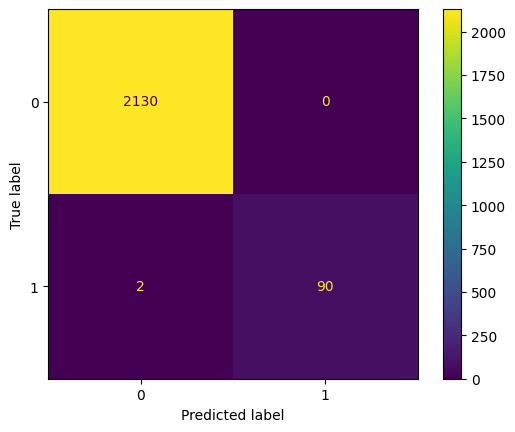

In [26]:
evaluar_modelo(dtc, test_data, test_labels)

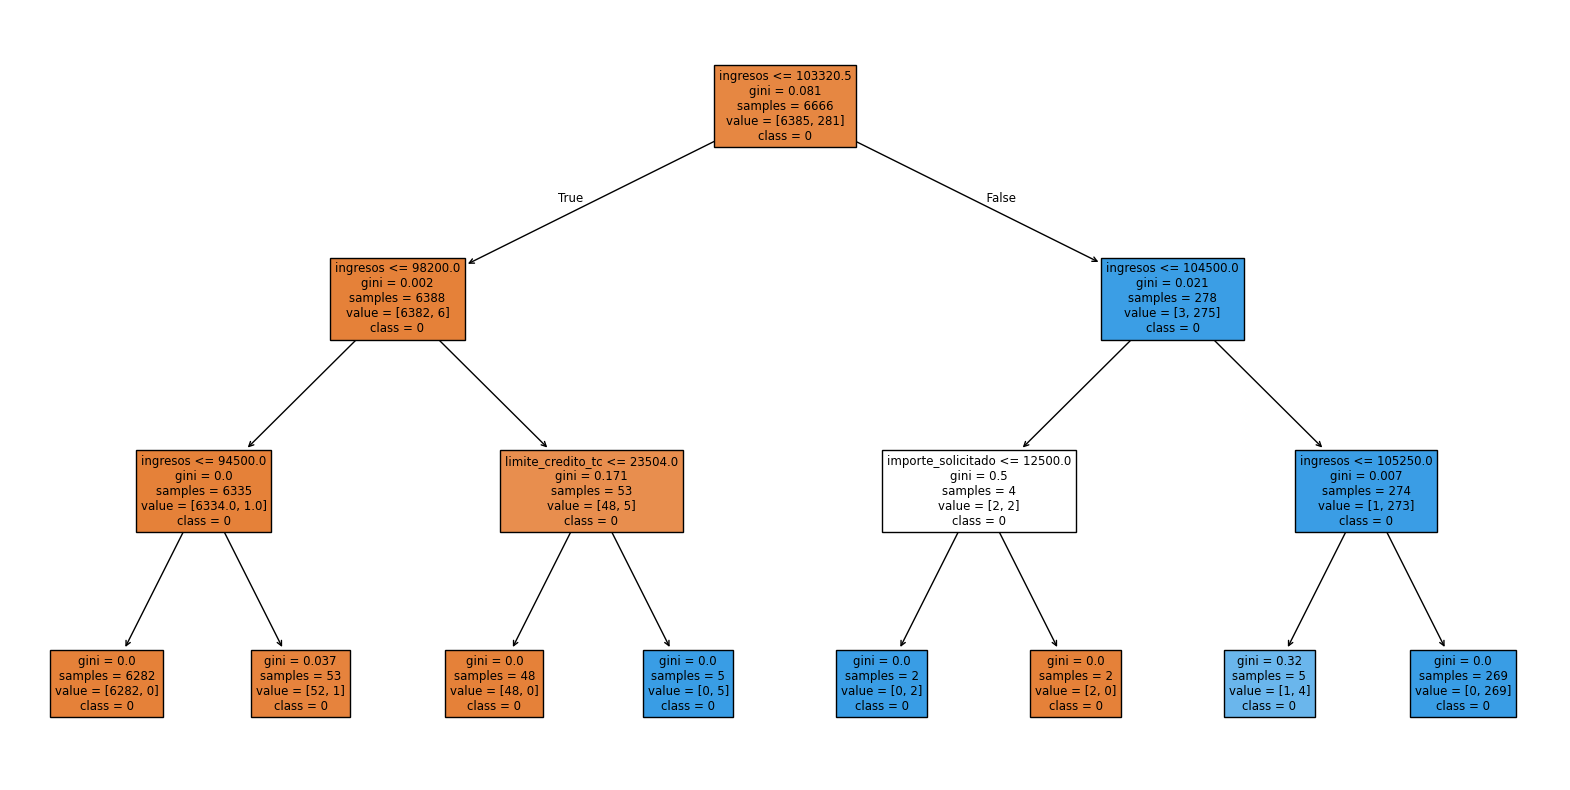

In [27]:
# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(dtc, filled=True, feature_names=data.columns, class_names=labels)
plt.show()
plt.close()

In [28]:
# Exportar las reglas del árbol
rules = export_text(dtc, feature_names=list(data.columns))
print(rules)

|--- ingresos <= 103320.50
|   |--- ingresos <= 98200.00
|   |   |--- ingresos <= 94500.00
|   |   |   |--- class: 0
|   |   |--- ingresos >  94500.00
|   |   |   |--- class: 0
|   |--- ingresos >  98200.00
|   |   |--- limite_credito_tc <= 23504.00
|   |   |   |--- class: 0
|   |   |--- limite_credito_tc >  23504.00
|   |   |   |--- class: 1
|--- ingresos >  103320.50
|   |--- ingresos <= 104500.00
|   |   |--- importe_solicitado <= 12500.00
|   |   |   |--- class: 1
|   |   |--- importe_solicitado >  12500.00
|   |   |   |--- class: 0
|   |--- ingresos >  104500.00
|   |   |--- ingresos <= 105250.00
|   |   |   |--- class: 1
|   |   |--- ingresos >  105250.00
|   |   |   |--- class: 1

